# Image Segmentation using Convolutional Neural Networks

This notebook is based on the example in the book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). Chp-09 to run in Google Colab and TF 2.6.

**It was modified in certain features and adapted to run in the following environment:**

- Windows 11
- Python 3.10.9
- TensorFlow 2.10.1
- VSCode 1.75.1
- CUDA 11.2
- CUDNN 11.2
- GPU: NVIDIA GeForce RTX 2060
- CPU: 06 Intel Core i7-10750 @2.6Ghz

### The data has been downloaded from:
- http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
- http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# gpu_options = tf.compat.v1.GPUOptions(allow_growth=True) 
# session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
# gpus = tf.config.experimental.list_physical_devices('GPU') for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

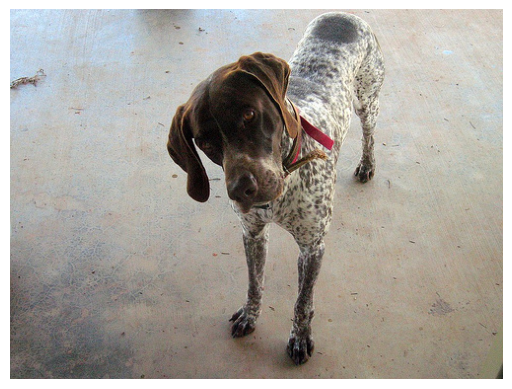

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[100]))

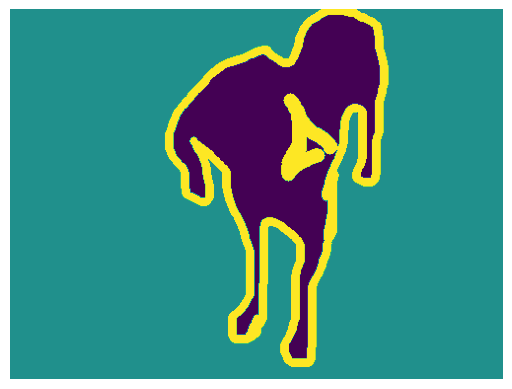

In [16]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[100], color_mode="grayscale"))
display_target(img)

In [8]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [9]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [10]:
# Be aware of potential OOM (Out of Memory error) and adjust the batch size accordingly (in this case I use a size of 2)
batch_size=2 #64
model.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, 
                    train_targets,
                    epochs=11, #50
                    callbacks=callbacks,
                    batch_size=batch_size,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/11
3195/3195 [==============================] - 79s 24ms/step - loss: 0.7574 - val_loss: 0.5564
Epoch 2/11
3195/3195 [==============================] - 76s 24ms/step - loss: 0.5603 - val_loss: 0.5184
Epoch 3/11
3195/3195 [==============================] - 78s 24ms/step - loss: 0.5175 - val_loss: 0.4796
Epoch 4/11
3195/3195 [==============================] - 78s 24ms/step - loss: 0.5490 - val_loss: 0.5120
Epoch 5/11
3195/3195 [==============================] - 77s 24ms/step - loss: 0.5284 - val_loss: 0.5015
Epoch 6/11
3195/3195 [==============================] - 80s 25ms/step - loss: 0.5238 - val_loss: 0.5660
Epoch 7/11
3195/3195 [==============================] - 79s 25ms/step - loss: 0.5343 - val_loss: 0.4884
Epoch 8/11
3195/3195 [==============================] - 79s 25ms/step - loss: 0.5204 - val_loss: 0.4726
Epoch 9/11
3195/3195 [==============================] - 80s 25ms/step - loss: 0.5147 - val_loss: 0.5850
Epoch 10/11
3195/3195 [==============================] - 79s 25m

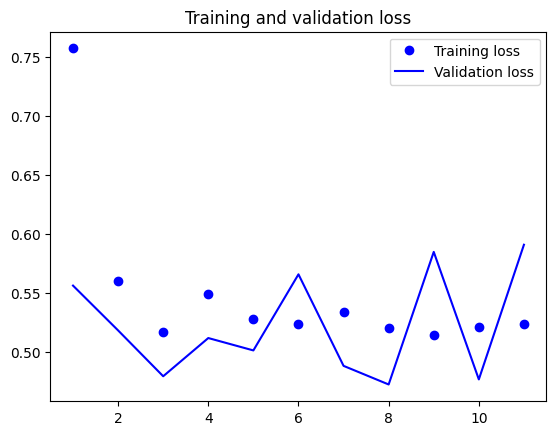

In [11]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

1/1 [==============================] - 0s 147ms/step


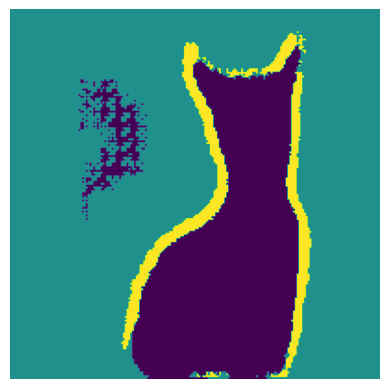

In [25]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 1
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)